In [1]:
%pip install pandas openpyxl matplotlib torch transformers nltk scikit-learn

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 11.2 MB/s eta 0:00:001m10.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.2 MB/s eta 0:00:0031m12.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.7 MB/s eta 0:00:00MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 11.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Load the evaluation data
with open('translation_evaluation_data.json', 'r') as f:
    evaluation_data = json.load(f)

# Load the T5 model and tokenizer
model_name = 't5-large'  # Adjust if using a different model
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
def translate_text(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    outputs = model.generate(input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def calculate_bleu_score(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    smoothing_function = SmoothingFunction().method4
    return sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing_function)

def calculate_cosine_similarity(reference, candidate):
    vectorizer = TfidfVectorizer().fit_transform([reference, candidate])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]


In [6]:
# Iterate through the evaluation data and compare translations
results = []
for entry in evaluation_data:
    prompt = entry["prompt"]
    ground_truth = entry["ground_truth"]
    translation = translate_text(prompt)
    
    # Calculate BLEU score
    bleu_score = calculate_bleu_score(ground_truth, translation)
    
    # Calculate Cosine Similarity
    cosine_sim = calculate_cosine_similarity(ground_truth, translation)
    
    results.append({
        "prompt": prompt,
        "ground_truth": ground_truth,
        "translation": translation,
        "match": translation.lower() == ground_truth.lower(),
        "bleu_score": bleu_score,
        "cosine_similarity": cosine_sim
    })

# Save the results to an Excel file
df = pd.DataFrame(results)
df.to_excel('translation_evaluation_results.xlsx', index=False)

/Users/alanabarrett-frew/Desktop/LLM/venv/lib/python3.11/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/alanabarrett-frew/Desktop/LLM/venv/lib/python3.11/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/alanabarrett-frew/Desktop/LLM/venv/lib/python3.11/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Users/alanabarrett-frew/Desktop/LLM/venv/lib/python3.11/site

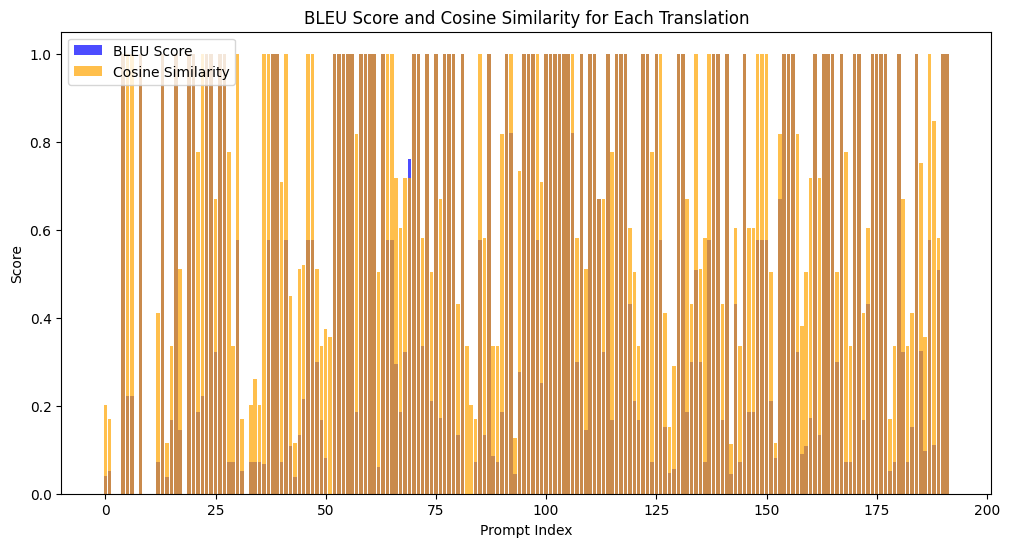

In [7]:
# Create a bar chart for BLEU scores and Cosine Similarity
plt.figure(figsize=(12, 6))
plt.bar(range(len(results)), [result['bleu_score'] for result in results], color='blue', alpha=0.7, label='BLEU Score')
plt.bar(range(len(results)), [result['cosine_similarity'] for result in results], color='orange', alpha=0.7, label='Cosine Similarity')

plt.xlabel('Prompt Index')
plt.ylabel('Score')
plt.title('BLEU Score and Cosine Similarity for Each Translation')
plt.legend()
plt.show()

In [8]:
# Calculate and display the average BLEU score and Cosine Similarity
average_bleu_score = sum(result['bleu_score'] for result in results) / len(results)
average_cosine_similarity = sum(result['cosine_similarity'] for result in results) / len(results)

print(f"Average BLEU Score: {average_bleu_score:.4f}")
print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")

Average BLEU Score: 0.5317
Average Cosine Similarity: 0.7263
